In [16]:
import cv2

cap = cv2.VideoCapture(0)

# Check if the webcam is opened correctly
if not cap.isOpened():
    raise IOError("Cannot open webcam")

while True:
    ret, frame = cap.read()
    frame = cv2.resize(frame, None, fx=2.0, fy=2.0, interpolation=cv2.INTER_AREA)
    cv2.imshow('Input', frame)

    c = cv2.waitKey(1)
    if c == 27:
        break

cap.release()
cv2.destroyAllWindows()

KeyboardInterrupt: 

In [7]:
import cv2
import os
import uuid
import time

In [3]:
IMAGES_PATH = os.path.join('data' , 'images')
number_images = 30


In [ ]:
cap = cv2.VideoCapture(0)
for image_num in  range(number_images):
    print('Collecting images {} ....'.format(image_num))
    ret,frame = cap.read()
    image_num = os.path.join(IMAGES_PATH , f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(image_num , frame)
    cv2.imshow('frame' , frame)
    time.sleep(0.5)

# if cv2.waitKey(1) & 0xFF == ord('q'):
#     break
    c = cv2.waitKey(1)
    if c == 27:
        break

cap.release()
cv2.destroyAllWindows()


In [ ]:
!labelme

[INFO   ] __init__:get_config:70 - Loading config file from: C:\Users\Juice\.labelmerc


### 

### Review Dataset and Build Image Load Function

In [8]:
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import numpy as np
import json 

In [5]:
### Limit GPU MEMORY GROWTH 
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu , True)

In [6]:
tf.config.list_physical_devices('GPU')

[]

### Load Image into TF Data Pipeline

In [9]:

images = tf.data.Dataset.list_files('data\\images\\*.jpg' , shuffle = False)
images.as_numpy_iterator().next()

InvalidArgumentError: Expected 'tf.Tensor(False, shape=(), dtype=bool)' to be true. Summarized data: b'No files matched pattern: data\\images\\*.jpg'

In [36]:
def load_image(x):
    byte_image = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_image)
    return img

In [28]:
images =  images.map(load_image)

NameError: name 'images' is not defined

In [10]:
images.as_numpy_iterator().next()

NameError: name 'images' is not defined

In [26]:
type(images)

tensorflow.python.data.ops.map_op._MapDataset

### View Images using Matplotlib Pyplot

In [11]:
image_generator = images.batch(4).as_numpy_iterator()

NameError: name 'images' is not defined

In [29]:
plot_images = image_generator.next()

NameError: name 'image_generator' is not defined

NameError: name 'plot_images' is not defined

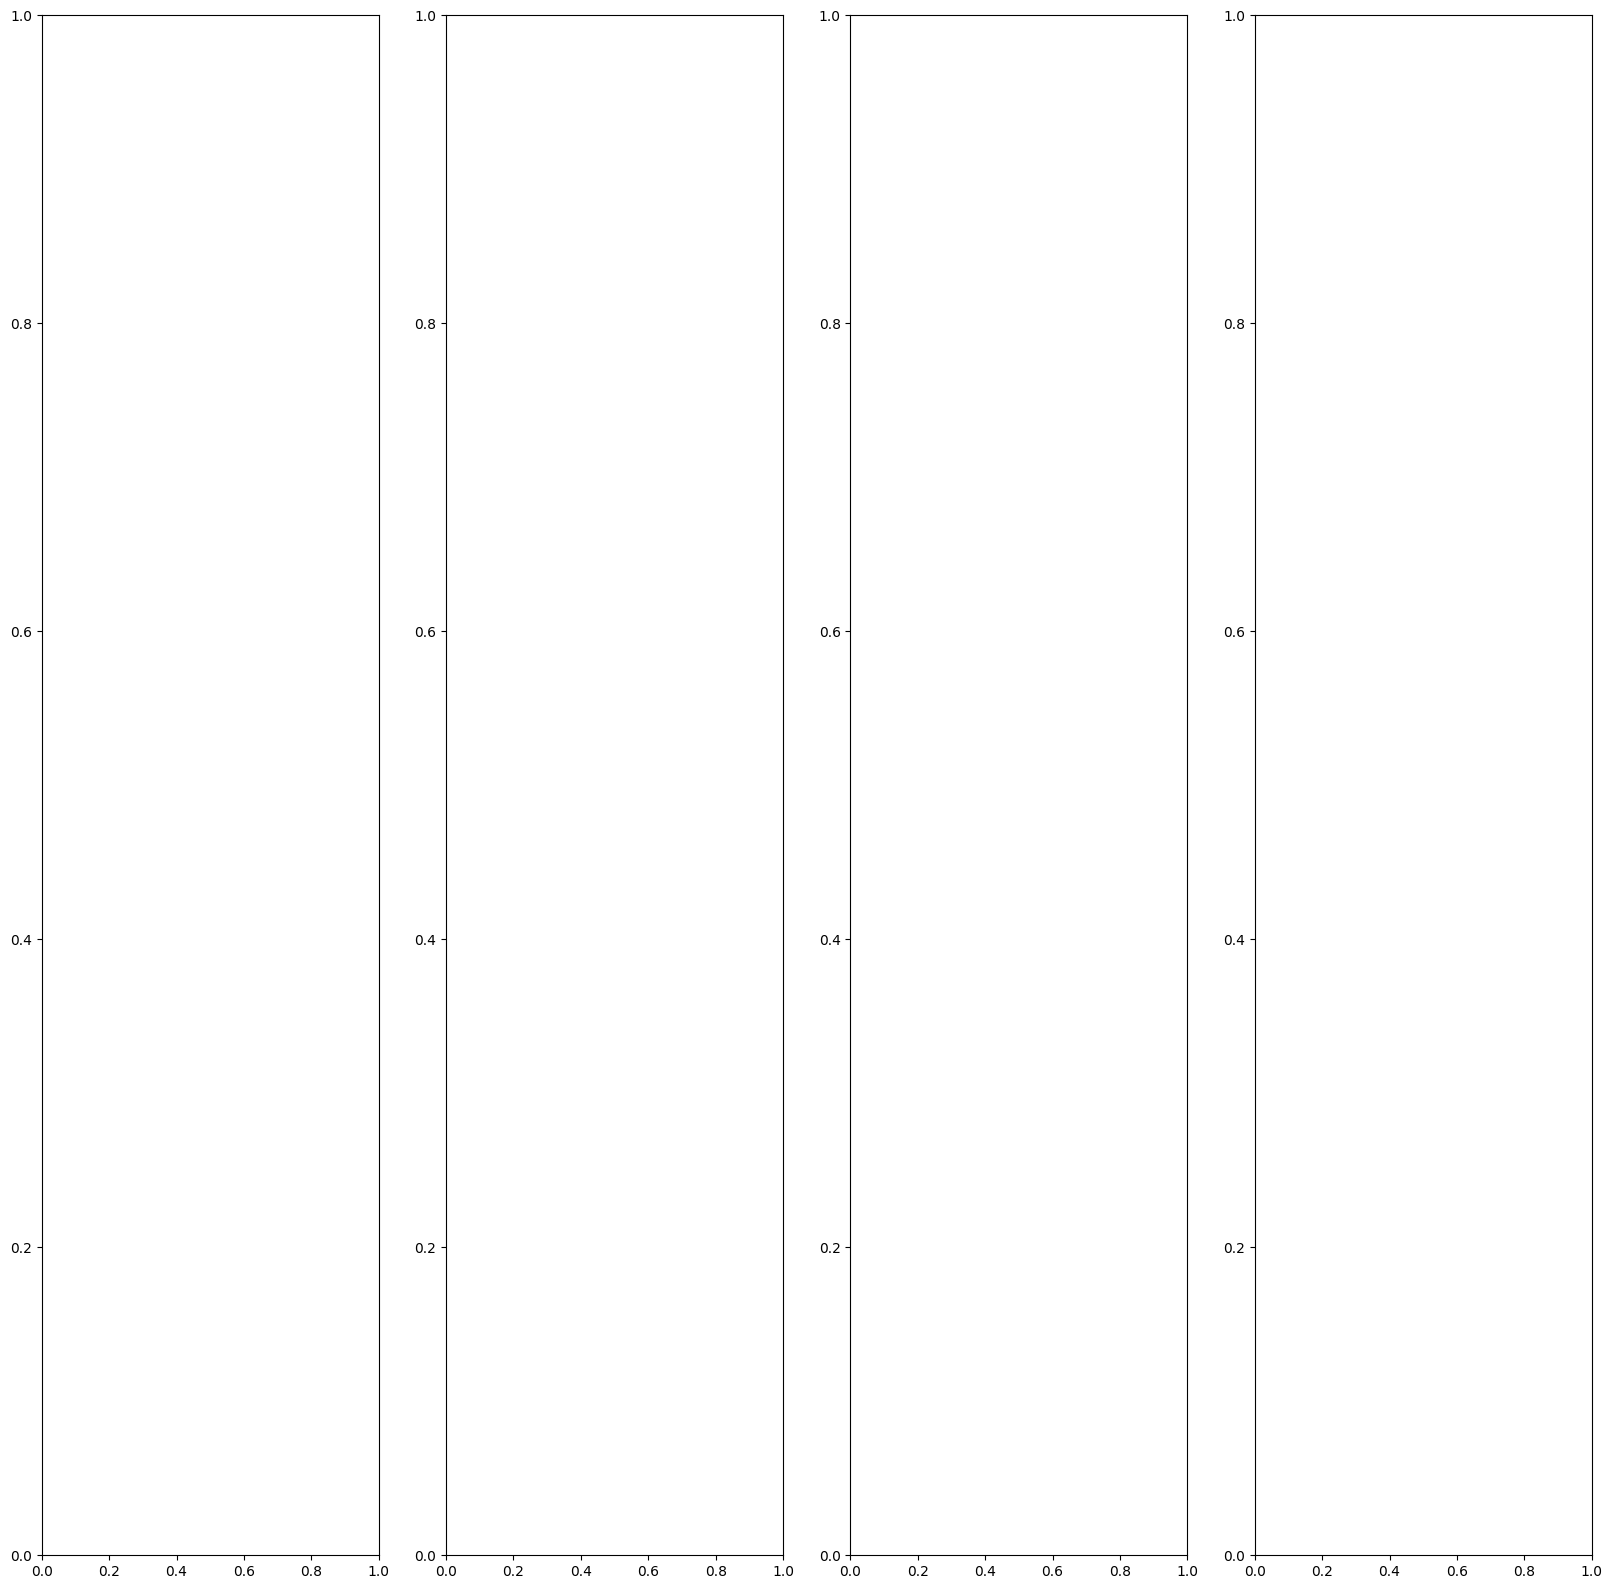

In [30]:
fig, ax = plt.subplots(ncols = 4 ,figsize = (20,20))
for idx , image in enumerate(plot_images):
    ax[idx].imshow(image)
plt.show()

### Manually Splitting Data Into Train Test and Validation Set

#### Move the Matching Labels 

In [31]:
import os
for folder in ['train' , 'test' , 'val']:
    for file in os.listdir(os.path.join('data' , folder , 'images')):

        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels' ,filename)
        if os.path.exists(existing_filepath):
               new_filepath = os.path.join('data',folder , 'labels' , filename)
               os.replace(existing_filepath , new_filepath)


     

### Apply Image Augmentation on Images And Labels Using Albumentations

#### Setting Up Albumentations Transform Pipeline


In [11]:
import albumentations as alb

In [12]:
augmentor = alb.Compose([alb.RandomCrop(width=450 , height=450),
                         alb.HorizontalFlip(p=0.5),
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.VerticalFlip(p=0.2),
                         alb.RandomGamma(p=0.2),
                         alb.RGBShift(p=0.2)
                         ],
                bbox_params = alb.BboxParams(format='albumentations' , label_fields=['class_labels']))

### Load A Test Image And Annotation with OpenCV and JSON ❤️

In [13]:
img = cv2.imread(os.path.join('data' , 'train' , 'images' ,'5c280f06-5bac-11ee-afef-287fcffcb6c8.jpg'))

In [16]:
img

array([[[246, 253, 255],
        [246, 253, 255],
        [246, 253, 255],
        ...,
        [212, 219, 228],
        [213, 218, 227],
        [214, 219, 228]],

       [[246, 253, 255],
        [246, 253, 255],
        [246, 253, 255],
        ...,
        [212, 219, 228],
        [214, 219, 228],
        [215, 220, 229]],

       [[246, 253, 255],
        [246, 253, 255],
        [246, 253, 255],
        ...,
        [213, 220, 229],
        [214, 219, 228],
        [215, 220, 229]],

       ...,

       [[253, 255, 255],
        [253, 255, 255],
        [253, 255, 255],
        ...,
        [250, 247, 249],
        [249, 246, 248],
        [248, 245, 247]],

       [[253, 255, 255],
        [253, 255, 255],
        [253, 255, 255],
        ...,
        [250, 247, 249],
        [250, 247, 249],
        [249, 246, 248]],

       [[253, 255, 255],
        [253, 255, 255],
        [253, 255, 255],
        ...,
        [250, 247, 249],
        [251, 248, 250],
        [250, 247, 249]]

In [14]:
img.shape

(480, 640, 3)

In [15]:
with open(os.path.join('data' , 'train' , 'labels' ,'5b71385b-5bac-11ee-b521-287fcffcb6c8.json') , 'r') as f:
    label = json.load(f)

In [16]:
label['shapes'][0]['points']

[[213.57541899441335, 186.3687150837989],
 [396.81564245810046, 436.64804469273747]]

In [17]:
type(label['shapes'])

list

In [18]:
### Extract Coordinates And Rescale to match Image Resolutions
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [19]:
coords

[213.57541899441335, 186.3687150837989, 396.81564245810046, 436.64804469273747]

In [20]:
coords = list(np.divide(coords  , [640 , 480 , 640 , 480]))

In [21]:
coords

[0.3337115921787709, 0.388268156424581, 0.6200244413407819, 0.9096834264432031]

### Apply Augumentations and View Results 


In [22]:
augmented = augmentor(image = img , bboxes = [coords] , class_labels = ['face'])

In [23]:
augmented['bboxes']

[(0.3292985723153323,
  0.3697082557417753,
  0.7364990689013036,
  0.9258845437616389)]

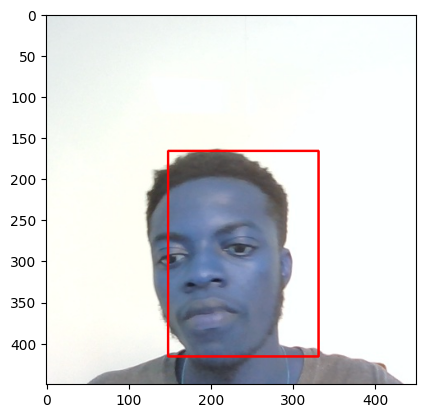

In [24]:
cv2.rectangle(augmented['image'],
              tuple(np.multiply(augmented['bboxes'][0][:2],[450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:],[450,450]).astype(int)),
              (255,0,0),2)

plt.imshow(augmented['image'])
              

### Build and Run Augmentation Pipeline


In [32]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(70):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

x_max is less than or equal to x_min for bbox [0.49345321229050276, 0.9294692737430168, 0.17920740223463683, 0.43365921787709494, 'face'].
x_max is less than or equal to x_min for bbox [0.4707576815642458, 0.85963687150838, 0.2001571229050279, 0.41620111731843573, 'face'].
x_max is less than or equal to x_min for bbox [0.5781249999999998, 0.7967877094972067, 0.3337115921787709, 0.3719739292364991, 'face'].
x_max is less than or equal to x_min for bbox [0.5720146648044692, 0.8922253258845438, 0.33720321229050276, 0.42900372439478585, 'face'].
x_max is less than or equal to x_min for bbox [0.7160439944134078, 0.8864059590316574, 0.4611557262569832, 0.40805400372439476, 'face'].
x_max is less than or equal to x_min for bbox [0.6086766759776536, 0.8142458100558659, 0.3433135474860335, 0.3929236499068901, 'face'].
x_max is less than or equal to x_min for bbox [0.5702688547486033, 0.8829143389199257, 0.17658868715083792, 0.07635009310986968, 'face'].
x_max is less than or equal to x_min for 

In [37]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

# train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
# train_images = train_images.map(load_image)

# # Resize images to (120, 120, 3) and normalize pixel values to [0, 1]
# def preprocess_image(image):
#     image = tf.image.resize(image, (120, 120))
#     image = tf.image.convert_image_dtype(image, tf.float32)  # Convert to float32
#     return image

# train_images = train_images.map(preprocess_image)

In [38]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

# test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
# test_images = test_images.map(load_image)

# # Resize images to (120, 120, 3) and normalize pixel values to [0, 1]
# def preprocess_image(image):
#     image = tf.image.resize(image, (120, 120))
#     image = tf.image.convert_image_dtype(image, tf.float32)  # Convert to float32
#     return image

# test_images = test_images.map(preprocess_image)

In [39]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

# val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
# val_images = val_images.map(load_image)

# # Resize images to (120, 120, 3) and normalize pixel values to [0, 1]
# def preprocess_image(image):
#     image = tf.image.resize(image, (120, 120))
#     image = tf.image.convert_image_dtype(image, tf.float32)  # Convert to float32
#     return image

# # val_images = val_images.map(preprocess_image)
# val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
# val_images = val_images.map(load_image)

# # Resize images to (120, 120, 3) and normalize pixel values to [0, 1]
# def preprocess_image(image):
#     image = tf.image.resize(image, (120, 120))
#     image = tf.image.convert_image_dtype(image, tf.float32)  # Convert to float32
#     return image

# val_images = val_images.map(preprocess_image)



In [40]:
train_images.as_numpy_iterator().next()

array([[[1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        ...,
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ]],

       [[1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        ...,
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ]],

       [[1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        ...,
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ]],

       ...,

       [[0.7973652 , 0.8032476 , 0.8615809 ],
        [0.7289216 , 0.73406863, 0.7858456 ],
        [0.7596201 , 0

### Prepare Labels 

In [41]:

def load_labels(label_path):
    with open(label_path.numpy()  , 'r' , encoding='utf-8') as f :
        label  = json.load(f)
    return [label['class']] , label['bbox']

### Load Labels To Tensorflow dataset

In [42]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json' , shuffle = False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels , [x] , [tf.uint8 , tf.float16]))


In [43]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json' , shuffle = False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels , [x] , [tf.uint8 , tf.float16]))


In [44]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json' , shuffle = False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels , [x] , [tf.uint8 , tf.float16]))

In [45]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.1569, 0.3896, 0.564 , 0.946 ], dtype=float16))

### Combine Label And Image Samples

* Check Amount of data used to Train , Test and Validate

In [46]:
len(train_images) , len(train_labels) , len(test_images) , len(test_labels) , len(val_images) , len(val_labels)

(3080, 3080, 910, 910, 490, 490)

### Create  Dataset (Images / Labels)

In [47]:
train = tf.data.Dataset.zip((train_images , train_labels))
train = train.shuffle(6000)
train = train.batch(8)
train.prefetch(4)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 120, 120, None), dtype=tf.float32, name=None), (TensorSpec(shape=<unknown>, dtype=tf.uint8, name=None), TensorSpec(shape=<unknown>, dtype=tf.float16, name=None)))>

In [48]:
test = tf.data.Dataset.zip((test_images , test_labels))
test = test.shuffle(1500)
test = test.batch(8)
test.prefetch(4)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 120, 120, None), dtype=tf.float32, name=None), (TensorSpec(shape=<unknown>, dtype=tf.uint8, name=None), TensorSpec(shape=<unknown>, dtype=tf.float16, name=None)))>

In [49]:
val = tf.data.Dataset.zip((val_images , val_labels))
val = val.shuffle(6000)
val = val.batch(8)
val.prefetch(4)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 120, 120, None), dtype=tf.float32, name=None), (TensorSpec(shape=<unknown>, dtype=tf.uint8, name=None), TensorSpec(shape=<unknown>, dtype=tf.float16, name=None)))>

In [50]:
train.as_numpy_iterator().next()[0].shape

(8, 120, 120, 3)

In [51]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [1],
        [0],
        [0],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.4023 , 0.09485, 0.7236 , 0.5034 ],
        [0.416  , 0.201  , 0.7236 , 0.4631 ],
        [0.1394 , 0.     , 0.7466 , 0.859  ],
        [0.     , 0.     , 0.     , 0.     ],
        [0.     , 0.     , 0.     , 0.     ],
        [0.1438 , 0.02837, 0.5024 , 0.3872 ],
        [0.     , 0.7065 , 0.10516, 1.     ],
        [0.3638 , 0.2361 , 0.6606 , 0.6445 ]], dtype=float16))

In [52]:
data_samples = train.as_numpy_iterator()

In [53]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


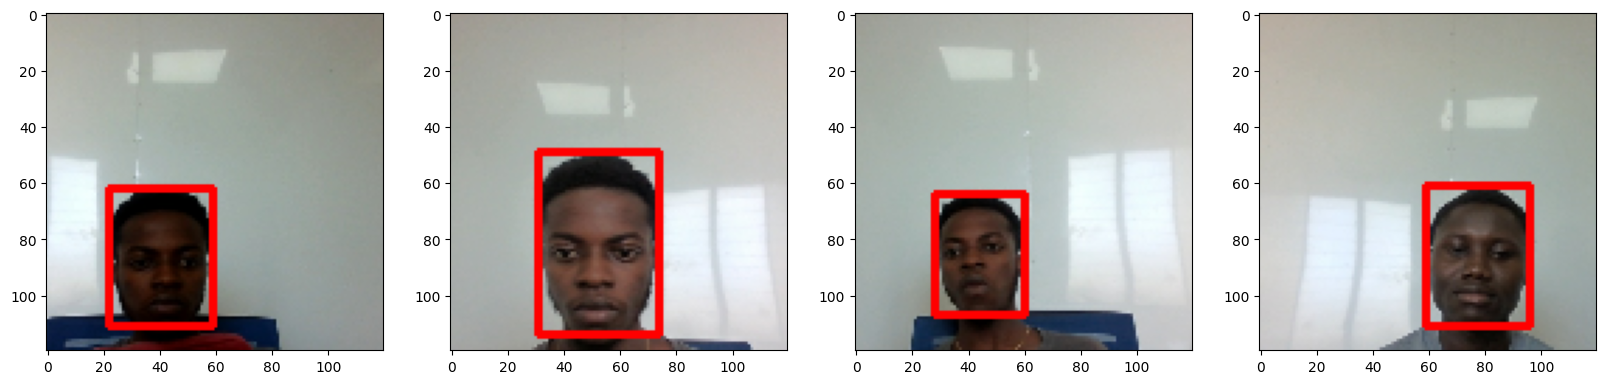

In [54]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

### Deep Learning With Keras Functional API

In [55]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input , Conv2D , MaxPooling2D , Dense , GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16


#####  Donwloading VGG16 which is a pre-trained Model

In [56]:
vgg = VGG16(include_top=False)

In [57]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

##### Build Instance of Network

In [59]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

In [60]:
facetracker = build_model()

In [61]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 120, 120, 3)]        0         []                            
                                                                                                  
 vgg16 (Functional)          (None, None, None, 512)      1471468   ['input_2[0][0]']             
                                                          8                                       
                                                                                                  
 global_max_pooling2d (Glob  (None, 512)                  0         ['vgg16[0][0]']               
 alMaxPooling2D)                                                                                  
                                                                                              

In [62]:
X , y = train.as_numpy_iterator().next()

In [63]:
X.shape

(8, 120, 120, 3)

In [64]:
X


array([[[[5.70159316e-01, 6.13296568e-01, 4.95649517e-01],
         [5.87928951e-01, 6.31066203e-01, 5.13419092e-01],
         [5.81556380e-01, 6.24693632e-01, 5.07046580e-01],
         ...,
         [7.22549021e-01, 7.22549021e-01, 6.12745106e-01],
         [7.29411781e-01, 7.29411781e-01, 6.19607866e-01],
         [7.24019587e-01, 7.24019587e-01, 6.14215672e-01]],

        [[5.82352936e-01, 6.25490189e-01, 5.07843137e-01],
         [5.84375024e-01, 6.27512276e-01, 5.09865224e-01],
         [5.88725507e-01, 6.31862760e-01, 5.14215708e-01],
         ...,
         [7.17279434e-01, 7.29044139e-01, 6.15318656e-01],
         [7.17218161e-01, 7.28982866e-01, 6.15257382e-01],
         [7.25980401e-01, 7.30392158e-01, 6.19117618e-01]],

        [[5.84987760e-01, 6.25674009e-01, 5.15379906e-01],
         [5.84375024e-01, 6.27512276e-01, 5.09865224e-01],
         [5.84313750e-01, 6.27451003e-01, 5.09803951e-01],
         ...,
         [7.14705884e-01, 7.26470590e-01, 6.20588243e-01],
         [

In [65]:
y

(array([[1],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.6045 , 0.6035 , 0.926  , 0.9746 ],
        [0.349  , 0.508  , 0.6743 , 0.945  ],
        [0.2072 , 0.1296 , 0.4753 , 0.46   ],
        [0.     , 0.     , 0.     , 0.     ],
        [0.562  , 0.3164 , 0.917  , 0.7295 ],
        [0.496  , 0.4656 , 0.8784 , 0.89   ],
        [0.3694 , 0.1432 , 0.752  , 0.568  ],
        [0.4375 , 0.05347, 0.7876 , 0.4768 ]], dtype=float16))

In [66]:
classes , coords = facetracker.predict(X)

1/1 [==============================] - 1s 701ms/step


In [67]:
classes , coords

(array([[0.7137078 ],
        [0.76069206],
        [0.7022152 ],
        [0.77234286],
        [0.790178  ],
        [0.7501532 ],
        [0.81979644],
        [0.7244941 ]], dtype=float32),
 array([[0.5349868 , 0.36141697, 0.6706191 , 0.34725207],
        [0.5240827 , 0.36720622, 0.6579348 , 0.3158092 ],
        [0.42715168, 0.35766146, 0.59057355, 0.31255448],
        [0.41485873, 0.39296672, 0.64189243, 0.2740887 ],
        [0.4829831 , 0.3049948 , 0.6576163 , 0.26467213],
        [0.5013894 , 0.39383867, 0.6701587 , 0.33029434],
        [0.53156894, 0.2887799 , 0.7103504 , 0.34106088],
        [0.48091525, 0.3234571 , 0.6210981 , 0.42352974]], dtype=float32))

### Losses And Optimizers

##### Define Optimizer and LR

In [68]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 - 1)/batches_per_epoch

In [69]:
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001 , decay = lr_decay)

### Localization Loss and Classification Loss

In [72]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [73]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

Testing Out The Loss Metrics

In [74]:
localization_loss(y[1] , coords)

<tf.Tensor: shape=(), dtype=float32, numpy=2.2010264>

In [75]:
classloss(y[0] , classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.43602404>

In [76]:
regressloss(y[1] ,coords)

<tf.Tensor: shape=(), dtype=float32, numpy=2.2010264>

### Train Neural Network

In [77]:
class FaceTracker(Model):
    def __init__(self,   eyetracker,  **kwargs):
        super().__init__(**kwargs)
        self.model = eyetracker
     

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt

    def train_step(self, batch, **kwargs):
        X, y = batch

        with tf.GradientTape() as tape:
            classes, coords = self.model(X, training=True)

            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)

            total_loss = batch_localizationloss + 0.5 * batch_classloss

            grad = tape.gradient(total_loss, self.model.trainable_variables)

        self.opt.apply_gradients(zip(grad, self.model.trainable_variables))

        return {"total_loss": total_loss, "class_loss": batch_classloss, "regress_loss": batch_localizationloss}

    def test_step(self, batch, **kwargs):
        X, y = batch

        classes, coords = self.model(X, training=False)

        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss + 0.5 * batch_classloss

        return {"total_loss": total_loss, "class_loss": batch_classloss, "regress_loss": batch_localizationloss}

    def call(self, X, **kwargs):
        return self.model(X, **kwargs)

# # Assuming your eyetracker model expects input shape (120, 120, 3)
# eyetracker_model = YourEyetrackerModel(input_shape=(120, 120, 3))

# # Create an instance of FaceTracker with the correct input shape and eyetracker model
# face_tracker = FaceTracker(eyetracker_model)


In [78]:
model  =FaceTracker(facetracker)

In [79]:
model.compile(opt , classloss , regressloss)

#### Train 


In [80]:
logdir = 'logs'

In [81]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [83]:
hist = model.fit(train.take(300), epochs=30, validation_data=val , callbacks = [tensorboard_callback])

Epoch 1/30


300/300 [==============================] - 546s 2s/step - total_loss: 0.2183 - class_loss: 0.0506 - regress_loss: 0.1930 - val_total_loss: 0.0187 - val_class_loss: 1.1126e-04 - val_regress_loss: 0.0187
Epoch 2/30
300/300 [==============================] - 549s 2s/step - total_loss: 0.0452 - class_loss: 0.0087 - regress_loss: 0.0408 - val_total_loss: 0.0233 - val_class_loss: 3.5632e-04 - val_regress_loss: 0.0232
Epoch 3/30
300/300 [==============================] - 518s 2s/step - total_loss: 0.0398 - class_loss: 0.0087 - regress_loss: 0.0355 - val_total_loss: 0.0118 - val_class_loss: 1.2548e-04 - val_regress_loss: 0.0117
Epoch 4/30
300/300 [==============================] - 1048s 3s/step - total_loss: 0.0199 - class_loss: 0.0020 - regress_loss: 0.0189 - val_total_loss: 0.0047 - val_class_loss: 1.3292e-05 - val_regress_loss: 0.0047
Epoch 5/30
300/300 [==============================] - 560s 2s/step - total_loss: 0.0071 - class_loss: 2.1838e-04 - regress_loss: 0.0070 - val_total_loss: 0.00

### Plotting the performance Of The Model

In [85]:
hist.history

{'total_loss': [0.05136708915233612,
  0.02613801695406437,
  0.013473455794155598,
  0.004068638663738966,
  0.008507207967340946,
  0.0048951623030006886,
  0.0021950548980385065,
  0.0017895352793857455,
  0.0016645058058202267,
  0.0015270388685166836,
  0.0028332117944955826,
  0.001101871719583869,
  0.0013215048238635063,
  0.00961458683013916,
  0.0037503312341868877,
  0.001866379869170487,
  0.0012309437151998281,
  0.002021024003624916,
  0.001331998035311699,
  0.002933711279183626,
  0.0016949244309216738,
  0.0007589452434331179,
  0.0016506401589140296,
  0.0009917060378938913,
  0.0007404732750728726,
  0.0008389229769818485,
  0.0003401281719561666,
  0.0011893906630575657,
  0.0017112991772592068,
  0.001383395167067647],
 'class_loss': [5.9608599258353934e-05,
  0.0008058286039158702,
  0.0005217402940616012,
  0.00020035041961818933,
  5.366931145545095e-05,
  7.679211557842791e-05,
  2.3790171326254494e-05,
  9.301724639954045e-05,
  6.06823232374154e-05,
  6.94809

In [2]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

NameError: name 'plt' is not defined

### Making Predictions

In [87]:
test_data = test.as_numpy_iterator()

In [88]:
test_sample = test_data.next()

In [89]:
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 0s 365ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


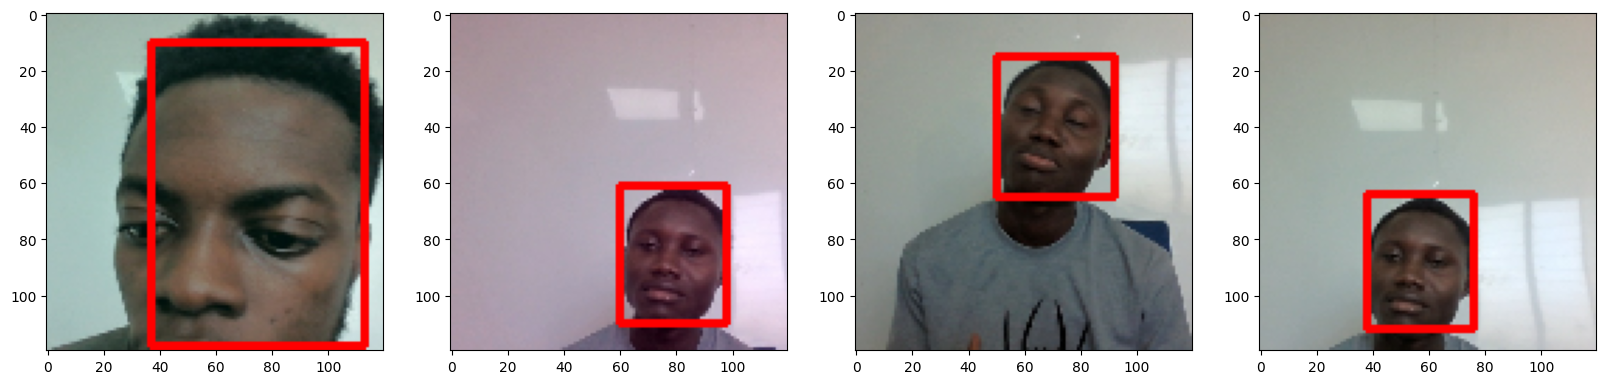

In [90]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

### Saving the Deep Learning Model 


In [91]:
from tensorflow.keras.models  import load_model

In [92]:
facetracker.save('facetracker.v1')

INFO:tensorflow:Assets written to: facetracker.v1\assets


INFO:tensorflow:Assets written to: facetracker.v1\assets


### Loading the Model 

In [93]:
facetracker = load_model('facetracker.v1')

In [ ]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()